In [2]:
%reset

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from matplotlib import pyplot as pl

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [4]:
#Prepare input

#Load data
names = []
rval = []
gval = []
bval = []
bad_chars = ['#', '$', '&', "'", '*', '\x80', '\x99', '\xa0', '\xa9', '\xba', '\xc3', '\xe2']
bad_char_string = ''.join(bad_chars)
maxlen = 45
line_len = []
with open('./data/colors.csv') as f:
    for li in f.readlines():
        line_nospecial = li.translate(None, bad_char_string)
        if (len(line_nospecial) < maxlen):
            line_split = line_nospecial.split(',')
            names.append(line_split[0])
            rval.append(float(line_split[1]))
            gval.append(float(line_split[2]))
            bval.append(float(line_split[3]))
            line_len.append(len(line_nospecial))

#List of names, properly formated with color values at end
names_withrgb = []
for ii in xrange(0,len(names)):
    names_withrgb.append(names[ii] + ': ' + str(rval[ii]) + ',' + str(gval[ii]) + ',' + str(bval[ii]))

#Now format input for RNN
end_char = '$' #demarcates end of color name
fill_char = '*' #fills in characters to get constant length
lengths = map(len, names_withrgb)
maxlength = np.max(lengths)+1 #since we add in end character
print "longest = ", names_withrgb[np.argmax(lengths)]
print "maxlength = ", maxlength

#turn string into a bunch of data points, filled in to have same length
def generate_data_points(string, maxlength):
    output = []
    for ii in xrange(1,len(string)+1):
        new_data_point = fill_char*(maxlength-ii) + string[0:ii]
        output.append(new_data_point)
    return output

all_data = []
for ii in xrange(0,len(names_withrgb)):
    all_data.extend(generate_data_points(names_withrgb[ii].lower() + end_char, maxlength))

#identify unique characters
chars = sorted(list(set(''.join(all_data))))
#Dictionary to convert characters to numbers
char_to_int = dict((c, i) for i, c in enumerate(chars))
#Dictionary to convert numbers to characters
int_to_char = dict((i, c) for i, c in enumerate(chars))
num_unique_chars = len(chars)

print "number of characters = ", len(chars)
dataX = []

#Prepare training data
dataY = []
for ii in xrange(0,len(all_data)):
    dataX.append([char_to_int[char] for char in (all_data[ii])[:-1]])
    dataY.append(char_to_int[(all_data[ii])[-1]])

num_samples = len(dataX)
X = np.reshape(dataX, (num_samples, maxlength-1, 1))
# normalize
X = X / float(num_unique_chars)
# one hot encode the output variable
y = np_utils.to_categorical(dataY)

print "characters = ", chars

longest =  International orange (aerospace): 1.0,0.31,0.0
maxlength =  47
number of characters =  48
characters =  [' ', '$', '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
# define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model_suffix = 'v1'

In [6]:
# define the checkpoint
filepath="./weights/weights-improvement-{epoch:02d}-{loss:.4f}-colors" + model_suffix + ".hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [7]:
model.fit(X, y, epochs=20, batch_size=32, callbacks=callbacks_list)

Epoch 1/1
43245/43245 [==============================] - 90s 2ms/step - loss: 2.5607

Epoch 00001: loss improved from inf to 2.56074, saving model to ./weights/weights-improvement-01-2.5607-colorsv1.hdf5


In [8]:
# load the network weights - one model is provided by default, but can replace with your own trained model
filename = "./weights/weights-improvement-20-1.3710-colorsv1.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [9]:
#Generate color using trained network

import bisect

def draw_rand(pdf):
    cdf = np.cumsum(pdf)
    rand = np.random.rand(1)
    rand_index = bisect.bisect(cdf, rand)
    return rand_index

def generate_new(model):
    seed_start = ''
    seed_string = (maxlength-len(seed_start)-1)*fill_char + seed_start
    print "seed string = ", seed_string
    seed = [char_to_int[value] for value in seed_string]
    output = '*'
    
    #Higher temperature means probabilities are closer to uniformly distributed
    temperature = 0.3
    prev_vector = np.copy(seed)
    while (output[-1] != end_char and len(output) < maxlength*10):
        prev_string = ''.join([int_to_char[prev_vector[i]] for i in np.arange(len(prev_vector))])
        #print "prev vector = ", prev_string
        x_shape = np.reshape(prev_vector, (1, maxlength-1, 1))
        x_norm = x_shape / float(num_unique_chars)
        probs = model.predict(x_norm, verbose=0)
        #adjust for temperature
        probs_temp = np.exp(np.log(probs)/temperature)
        probs_temp = probs_temp/np.sum(probs_temp)
        
        #draw next character from probability distribution
        index = draw_rand(probs_temp)
        result = int_to_char[index]
            
        #add to output and shift prev_vector over one character
        output += result
        prev_vector = np.append(prev_vector[1:],index)
        
    output_formatted = output.translate(None, end_char+fill_char)
    return output_formatted
   

new_color = generate_new(model)
print "new color = ", new_color

seed string =  **********************************************
new color =  sale: 0.79,0.94,0.69


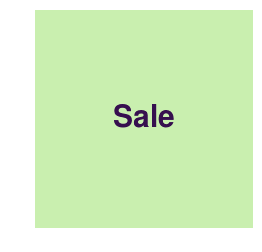

In [11]:
#Display color
color_name_string, color_val_string = new_color.split(':')
rgb_strings = color_val_string.split(',')
rval, gval, bval = float(rgb_strings[0]), float(rgb_strings[1]), float(rgb_strings[2])
color_name_print = r'$\textbf{' + color_name_string[0].upper() + color_name_string[1:] + '}$'
display_mat = np.zeros((1,1,3))
display_mat[0,0,0] = rval
display_mat[0,0,1] = gval
display_mat[0,0,2] = bval


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

fig, ax = pl.subplots(1,1)
ax.imshow(display_mat)
ax.axis('off')
ax.text(0.5, 0.5, color_name_print, size = '30', color = 1.-display_mat[0,0,:], horizontalalignment='center',  verticalalignment='center', transform=ax.transAxes)
print ""